In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.models.rnn import rnn, rnn_cell, seq2seq

In [2]:
sess = None
sess = tf.InteractiveSession()

In [3]:
def make_loop_function(input_elements, memory_cell, soft=True):
    """
    Args:
      input_elements: List of [batch_size * cell.input_dim]
    """
    seq_length = len(input_elements)
    input_elements = tf.concat(1, [tf.expand_dims(input_t, 1)
                                   for input_t in input_elements])
    
    def loop_function(output_t, t):
        if soft:
            softmax = tf.nn.softmax(output_t)
            weighted_inputs = input_elements * tf.expand_dims(softmax, 2)
            processed = tf.reduce_sum(weighted_inputs, 1)
        else:
            # TODO
            pass
        
        return processed
    
    return loop_function

In [4]:
tf.ops.reset_default_graph()

In [5]:
seq_length = 5
batch_size = 64

vocab_size = 10
embedding_dim = 50

memory_dim = 100

In [6]:
inp = [tf.placeholder(tf.int32, shape=(batch_size,),
                      name="inp%i" % t)
       for t in range(seq_length)]
labels = [tf.placeholder(tf.int32, shape=(batch_size,),
                        name="labels%i" % t)
          for t in range(seq_length)]
weights = [tf.ones_like(labels_t, dtype=tf.float32)
           for labels_t in labels]
prev_mem = tf.zeros((batch_size, memory_dim))

In [7]:
cell = rnn_cell.GRUCell(memory_dim)
cell = rnn_cell.EmbeddingWrapper(cell, vocab_size)

enc_outputs, enc_states = rnn.rnn(cell, inp, dtype=tf.float32)

In [8]:
with tf.variable_scope("RNN/EmbeddingWrapper", reuse=True):
    embeddings = tf.get_variable("embedding")
    inp_embedded = [tf.nn.embedding_lookup(embeddings, inp_t)
                    for inp_t in inp]

cell = rnn_cell.GRUCell(memory_dim)
attn_states = tf.concat(1, [tf.reshape(e, [-1, 1, cell.output_size])
                            for e in enc_outputs])
dec_inp = [tf.zeros((batch_size, cell.input_size), dtype=tf.float32)
           for _ in range(seq_length)]

dec_outputs, dec_states = seq2seq.attention_decoder(dec_inp, enc_states[-1],
                                                    attn_states, cell, output_size=seq_length,
                                                    loop_function=make_loop_function(inp_embedded, cell))

In [9]:
loss = seq2seq.sequence_loss(dec_outputs, labels, weights, seq_length)

In [10]:
learning_rate = 0.05
momentum = 0.9
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
train_op = optimizer.minimize(loss)
summary_op = loss # tf.merge_all_summaries()

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

def train_batch(batch_size):
    X = [np.random.choice(vocab_size, size=(seq_length,), replace=False)
         for _ in range(batch_size)]
    y = [np.argsort(x) for x in X] # [np.arange(seq_length) for _ in X]
    
    # Dimshuffle to seq_len * batch_size
    X = np.array(X).T
    y = np.array(y).T

    feed_dict = {inp[t]: X[t] for t in range(seq_length)}
    feed_dict.update({labels[t]: y[t] for t in range(seq_length)})

    loss = sess.run([train_op, summary_op], feed_dict)[1]
    print loss
    return loss

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7fe5b54a8c90>> ignored


In [11]:
train_batch(batch_size)

1.62184


1.621842

In [12]:
loss_history = [train_batch(batch_size) for _ in xrange(3000)]

1.62233
1.6222
1.61777
1.61692
1.61422
1.61377
1.61396
1.6105
1.61219
1.61404
1.61022
1.6137
1.6138
1.61171
1.61075
1.60618
1.60812
1.61003
1.61122
1.60435
1.60688
1.6038
1.60934
1.60873
1.60383
1.6076
1.60333
1.60498
1.60278
1.60388
1.60044
1.60218
1.60487
1.60631
1.60605
1.60745
1.6041
1.60254
1.60287
1.60449
1.60388
1.6045
1.59686
1.60128
1.60365
1.59941
1.6024
1.59553
1.5985
1.60125
1.59689
1.59408
1.59918
1.60062
1.59599
1.59643
1.59856
1.59311
1.59341
1.60272
1.59078
1.59549
1.59119
1.59226
1.59026
1.59333
1.58785
1.58883
1.59216
1.58735
1.59192
1.59313
1.58804
1.58698
1.58875
1.58142
1.57957
1.58022
1.58336
1.58304
1.581
1.58547
1.57344
1.57949
1.57507
1.56091
1.55978
1.5663
1.57077
1.56257
1.56178
1.55691
1.55775
1.55817
1.54749
1.53904
1.56429
1.5539
1.55742
1.54729
1.54722
1.51848
1.53336
1.5384
1.52489
1.55553
1.53125
1.54108
1.51038
1.51032
1.5239
1.52095
1.51092
1.53184
1.50186
1.46707
1.48885
1.47302
1.48654
1.49918
1.48946
1.51659
1.49903
1.48308
1.49447
1.48167
1.45787


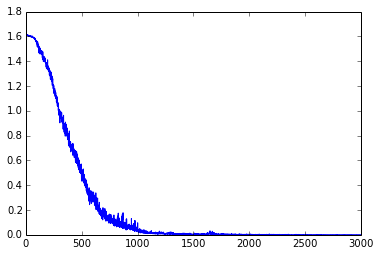

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(loss_history)